In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/scratch2/jsalle/ObsScaling


In [2]:
# SAD benchmarks
sad_eval = pd.read_csv("./eval_results/sad_benchmark_results.csv")
sad_eval.rename(columns={'model': 'Model'}, inplace=True)
sad_eval_models = sad_eval['Model'].unique().tolist()

In [3]:
sad_models = sad_eval["Model"].unique().tolist()
sad_types = sad_eval["type"].unique().tolist()
sad_variants = sad_eval["variant"].unique().tolist()


sad_intermediary_df = pd.DataFrame()

for model in sad_models:
    temp_dict = {
        "Model": model,
    }

    for t in sad_types:
        for v in sad_variants:
            temp_dict.update(
                {f'{t}_{v}': sad_eval[(sad_eval["Model"] == model) & (sad_eval["type"] == t) & (sad_eval["variant"] == v)]["score"].values[0]}
            )
    temp_df = pd.DataFrame(temp_dict, index=[0])

    sad_intermediary_df = pd.concat([sad_intermediary_df, temp_df], axis=0, ignore_index=True)


for c in sad_intermediary_df.columns:
    if ' ' in c:
        sad_intermediary_df.rename(columns={c: c.replace(' ', '_')}, inplace=True)

sad_intermediary_df

,Model,SAD_Plain_Prompt,SAD_Situating_Prompt,SAD-lite_Plain_Prompt,SAD-lite_Situating_Prompt,SAD-mini_Plain_Prompt,SAD-mini_Situating_Prompt,facts_Plain_Prompt,facts_Situating_Prompt,influence_Plain_Prompt,...,introspection_Plain_Prompt,introspection_Situating_Prompt,stages_Plain_Prompt,stages_Situating_Prompt,self-recognition_Plain_Prompt,self-recognition_Situating_Prompt,id-leverage_Plain_Prompt,id-leverage_Situating_Prompt,anti-imitation_Plain_Prompt,anti-imitation_Situating_Prompt
0,llama-2-7b,0.328841,0.306368,0.364873,0.340016,0.471816,0.418833,0.385027,0.360935,0.531250,...,0.379519,0.373241,0.374375,0.364375,0.500000,0.500000,0.038503,0.024060,0.093214,0.090714
1,llama-2-7b-chat,0.301525,0.313693,0.309089,0.331158,0.387865,0.452488,0.391385,0.441408,0.384375,...,0.215519,0.213593,0.347656,0.352656,0.500000,0.500000,0.255311,0.187394,0.016429,0.016429
2,llama-2-13b,0.323594,0.334734,0.353455,0.365446,0.421750,0.449539,0.376201,0.408362,0.450000,...,0.350194,0.346815,0.355625,0.376250,0.500000,0.500000,0.034209,0.027695,0.198929,0.205893
3,llama-2-13b-chat,0.349043,0.376247,0.355007,0.390173,0.489223,0.552331,0.486278,0.541054,0.518750,...,0.227463,0.220500,0.396406,0.408281,0.512500,0.568750,0.286907,0.252642,0.015000,0.042500
4,llama-2-70b,0.322603,0.351961,0.354197,0.391297,0.495903,0.585435,0.428984,0.509020,0.562500,...,0.229713,0.218074,0.380625,0.366250,0.500625,0.500000,0.024703,0.024309,0.131071,0.133571
5,llama-2-70b-chat,0.365819,0.402261,0.374817,0.416498,0.509007,0.618683,0.505382,0.583412,0.556250,...,0.228065,0.228546,0.384375,0.423125,0.541250,0.528750,0.317556,0.328511,0.027857,0.032857
6,llama-3-70b-chat,0.451451,0.493406,0.452624,0.500807,0.606390,0.691563,0.565677,0.641054,0.653125,...,0.348130,0.358046,0.469062,0.484375,0.656875,0.736875,0.444964,0.439295,0.022321,0.022321
7,davinci-002,0.293974,0.300627,0.323768,0.331345,0.413500,0.429911,0.361013,0.386524,0.421875,...,0.239769,0.234178,0.366875,0.356250,0.505625,0.506250,0.008729,0.011011,0.153929,0.153929
8,gpt-3.5-turbo-0613,0.358278,0.384165,0.368927,0.405154,0.468703,0.546873,0.510929,0.572572,0.476562,...,0.237456,0.248857,0.398750,0.413906,0.510625,0.508125,0.306299,0.311186,0.067321,0.067321
9,gpt-4-base,0.367979,0.392918,0.400690,0.426456,0.571579,0.621953,0.481007,0.621154,0.621875,...,0.344156,0.350357,0.473125,0.433125,0.459375,0.444375,0.028103,0.039450,0.168214,0.168214


In [4]:
sad_intermediary_df.columns.tolist()

['Model',
 'SAD_Plain_Prompt',
 'SAD_Situating_Prompt',
 'SAD-lite_Plain_Prompt',
 'SAD-lite_Situating_Prompt',
 'SAD-mini_Plain_Prompt',
 'SAD-mini_Situating_Prompt',
 'facts_Plain_Prompt',
 'facts_Situating_Prompt',
 'influence_Plain_Prompt',
 'influence_Situating_Prompt',
 'introspection_Plain_Prompt',
 'introspection_Situating_Prompt',
 'stages_Plain_Prompt',
 'stages_Situating_Prompt',
 'self-recognition_Plain_Prompt',
 'self-recognition_Situating_Prompt',
 'id-leverage_Plain_Prompt',
 'id-leverage_Situating_Prompt',
 'anti-imitation_Plain_Prompt',
 'anti-imitation_Situating_Prompt']

Missing values in training data: 0.00%


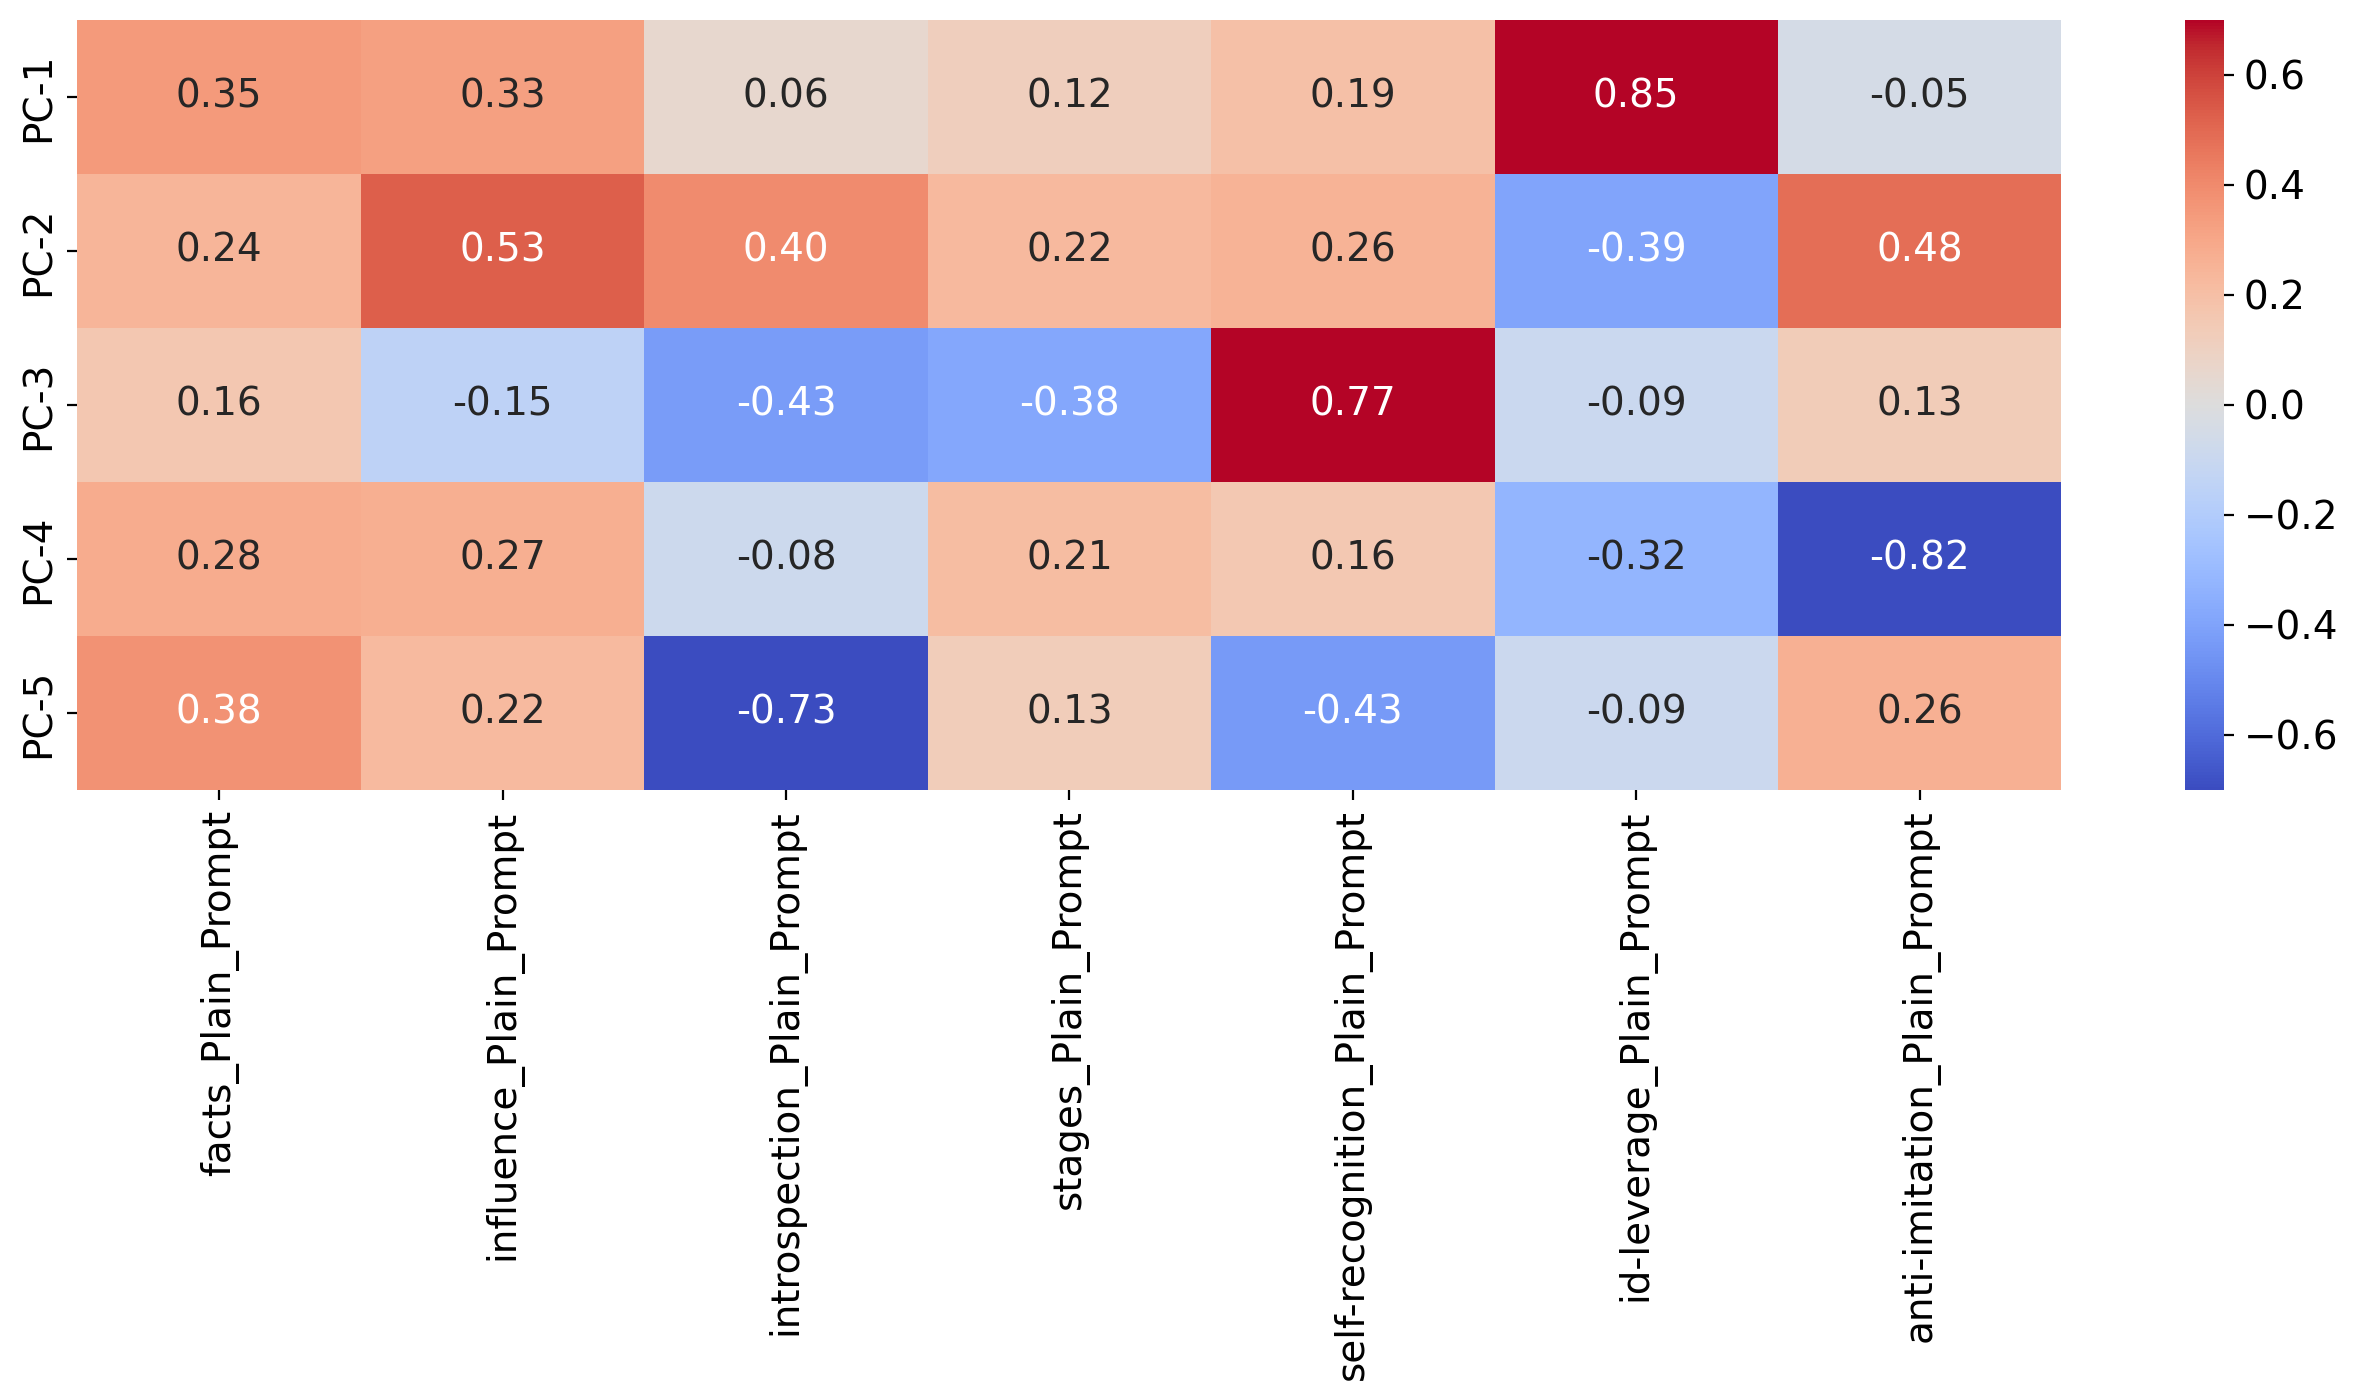

In [5]:
pca_impute_metrics = ['facts_Plain_Prompt', 'influence_Plain_Prompt', 'introspection_Plain_Prompt', 'stages_Plain_Prompt',
                      'self-recognition_Plain_Prompt', 'id-leverage_Plain_Prompt', 'anti-imitation_Plain_Prompt']
metric_df = sad_intermediary_df[pca_impute_metrics]

impute_kwargs = DEFAULT_PCA_PREPROCESS_KWARGS['imputation_kwargs'].copy()
impute_kwargs['verbose'] = True
imputed_metric_df, _ = pca_impute(metric_df, **impute_kwargs)

pca, imputed_metric_pc, _ = perform_pca(imputed_metric_df, **DEFAULT_PCA_PREPROCESS_KWARGS['pca_kwargs']) 

fig, ax = plt.subplots(figsize=(16, 5))

# nicer visualization: make the PC dims mostly "postively" correlated to model performance
vis_weights = pca.components_.copy()
for idx in [1, 3, 4]:
    vis_weights[idx] *= -1

sns.heatmap(vis_weights, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, vmin=-0.7, vmax=0.7)
ax.set_yticklabels(imputed_metric_pc.columns)
ax.set_xticklabels(pca_impute_metrics, rotation=90)

plt.show()

/tmp/ipykernel_483553/157253771.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(1, n_components+1))


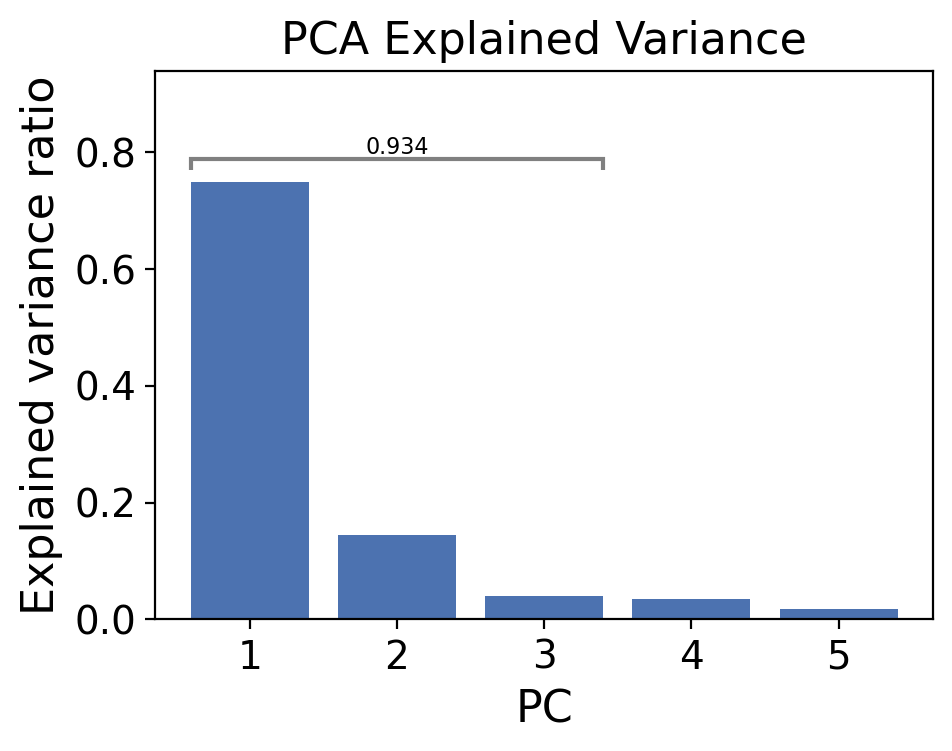

In [6]:
import matplotlib.patches as patches
from matplotlib.path import Path

n_components = DEFAULT_PCA_PREPROCESS_KWARGS['pca_kwargs']['n_components']
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar(range(1, n_components + 1), pca.explained_variance_ratio_)

ax.set_xticklabels(range(1, n_components+1))
ax.set_xticks(range(1, n_components+1))
ax.set_xlabel("PC")
ax.set_ylabel("Explained variance ratio")

top_n = 3

sum_top_n = pca.explained_variance_ratio_[:top_n].sum() 

# Draw a custom curly brace (half bracket) above the top 3 bars
brace_height = max(pca.explained_variance_ratio_[:top_n]) + 0.02  # Slightly higher to clear the bars
brace_x_start = 1 - 0.4  # Slightly before the first bar
brace_x_end = 3 + 0.4   # Slightly past the third bar

# Define the points for the path (a simple upside-down half-bracket)
vertices = [
    (brace_x_start, brace_height),  # Left bottom of the brace
    (brace_x_start, brace_height + 0.02),  # Left top of the brace
    (brace_x_end, brace_height + 0.02),  # Right top of the brace
    (brace_x_end, brace_height),  # Right bottom of the brace
]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]

path = Path(vertices, codes)
patch = patches.PathPatch(path, facecolor='none', lw=1.5, edgecolor='gray')
ax.add_patch(patch)

# Annotation for the brace
ax.annotate(f"{sum_top_n:.3f}", 
            ((brace_x_start + brace_x_end) / 2, brace_height + 0.02),  # Position for the text
            textcoords="data",
            ha="center", va="bottom", fontsize=8)
ax.set_title("PCA Explained Variance")

ax.set_ylim([0.0, 0.94])

plt.tight_layout()

plt.show()

In [15]:
from utils.helper import load_base_llm_benchmark_eval
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"
post_training_eval = pd.read_csv(eval_result_path)

base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model", how='outer')

# MMLU subtasks
mmlu_df = load_acc_mmlu_subtasks()
merged_eval = merge_benchmarks_with_init_df(base_llm_eval_with_post_training, mmlu_df)

# MBPP
#mbpp_df = pd.read_csv("./eval_results/mbpp_eval.csv")
#merged_eval = pd.merge(merged_eval, mbpp_df, on='Model', how='left')

In [16]:
sad_intermediary_df

,Model,SAD_Plain_Prompt,SAD_Situating_Prompt,SAD-lite_Plain_Prompt,SAD-lite_Situating_Prompt,SAD-mini_Plain_Prompt,SAD-mini_Situating_Prompt,facts_Plain_Prompt,facts_Situating_Prompt,influence_Plain_Prompt,...,introspection_Plain_Prompt,introspection_Situating_Prompt,stages_Plain_Prompt,stages_Situating_Prompt,self-recognition_Plain_Prompt,self-recognition_Situating_Prompt,id-leverage_Plain_Prompt,id-leverage_Situating_Prompt,anti-imitation_Plain_Prompt,anti-imitation_Situating_Prompt
0,llama-2-7b,0.328841,0.306368,0.364873,0.340016,0.471816,0.418833,0.385027,0.360935,0.531250,...,0.379519,0.373241,0.374375,0.364375,0.500000,0.500000,0.038503,0.024060,0.093214,0.090714
1,llama-2-7b-chat,0.301525,0.313693,0.309089,0.331158,0.387865,0.452488,0.391385,0.441408,0.384375,...,0.215519,0.213593,0.347656,0.352656,0.500000,0.500000,0.255311,0.187394,0.016429,0.016429
2,llama-2-13b,0.323594,0.334734,0.353455,0.365446,0.421750,0.449539,0.376201,0.408362,0.450000,...,0.350194,0.346815,0.355625,0.376250,0.500000,0.500000,0.034209,0.027695,0.198929,0.205893
3,llama-2-13b-chat,0.349043,0.376247,0.355007,0.390173,0.489223,0.552331,0.486278,0.541054,0.518750,...,0.227463,0.220500,0.396406,0.408281,0.512500,0.568750,0.286907,0.252642,0.015000,0.042500
4,llama-2-70b,0.322603,0.351961,0.354197,0.391297,0.495903,0.585435,0.428984,0.509020,0.562500,...,0.229713,0.218074,0.380625,0.366250,0.500625,0.500000,0.024703,0.024309,0.131071,0.133571
5,llama-2-70b-chat,0.365819,0.402261,0.374817,0.416498,0.509007,0.618683,0.505382,0.583412,0.556250,...,0.228065,0.228546,0.384375,0.423125,0.541250,0.528750,0.317556,0.328511,0.027857,0.032857
6,llama-3-70b-chat,0.451451,0.493406,0.452624,0.500807,0.606390,0.691563,0.565677,0.641054,0.653125,...,0.348130,0.358046,0.469062,0.484375,0.656875,0.736875,0.444964,0.439295,0.022321,0.022321
7,davinci-002,0.293974,0.300627,0.323768,0.331345,0.413500,0.429911,0.361013,0.386524,0.421875,...,0.239769,0.234178,0.366875,0.356250,0.505625,0.506250,0.008729,0.011011,0.153929,0.153929
8,gpt-3.5-turbo-0613,0.358278,0.384165,0.368927,0.405154,0.468703,0.546873,0.510929,0.572572,0.476562,...,0.237456,0.248857,0.398750,0.413906,0.510625,0.508125,0.306299,0.311186,0.067321,0.067321
9,gpt-4-base,0.367979,0.392918,0.400690,0.426456,0.571579,0.621953,0.481007,0.621154,0.621875,...,0.344156,0.350357,0.473125,0.433125,0.459375,0.444375,0.028103,0.039450,0.168214,0.168214
